In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
import re,string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import math
import random
from sklearn.metrics import confusion_matrix
import heapq
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

random.seed(10)

# Importring the required data for training

In [2]:
%%time
train = pd.read_csv('sentiment_tweets3.csv')
with open('epdf.pub_inverting-the-pyramid-a-history-of-football-tactics.txt', 'r') as file:
    football = file.read().replace('\n', '')
weather = pd.read_csv('weather-agg-DFE.csv')
with open('players_desc.txt', 'r') as file:
    players = file.read().replace('\n', '')


CPU times: user 18.9 ms, sys: 4.56 ms, total: 23.5 ms
Wall time: 30.3 ms


In [3]:
train = train.rename(columns={'message to examine':'tweet','label (depression result)':'label'})

# Function for preprocessing:
To remove the punctuation, stop words and lemmatize and find the stem of the word

In [4]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

ps = PorterStemmer()

eng_stopwords = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    
    text = re.sub(r"http\S+", "", text)
    punct = list(string.punctuation)
    punct.append('’')
    punct.append('‘')
    punct.append('”')
    punct.append('–')
    
    text = "".join([a for a in text if a not in punct])
    
    text = re.sub(r"\d", " ", text)
    
    text = re.sub(r"\s+", " ", text)
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token not in eng_stopwords]
    tokens = [ps.stem(token) for token in tokens]
    
    return ' '.join(tokens)

In [5]:
positive = train[train['label'] == 0].reset_index(drop=True)
negative = train[train['label'] == 1].reset_index(drop=True)

# Training Text Preprocessing:
Splitting the training texts which come eithe rin the form of tweets or texts into words and applying the preprocessing function

In [7]:
positive['tweet'] = positive['tweet'].apply(preprocess_text)
total_positive = positive['tweet'].to_list()
total_positive = ' '.join(total_positive)
total_positive = total_positive.split(' ')
print(len(total_positive))


60492


In [8]:
negative['tweet'] = negative['tweet'].apply(preprocess_text)
total_negative = negative['tweet'].to_list()
total_negative = ' '.join(total_negative)
total_negative = total_negative.split(' ')
print(len(total_negative))

31254


In [9]:
weather['tweet_text'] = weather['tweet_text'].apply(preprocess_text)
total_weather = weather['tweet_text'].to_list()
total_weather = ' '.join(total_weather)
total_weather = total_weather.split(' ')
print(len(total_weather))

9325


In [10]:
football_text = preprocess_text(football)
total_football = football_text.split(' ')
print(len(total_football))

68214


In [11]:
player_text = preprocess_text(players)
total_player = player_text.split(' ')
print(len(total_player))

10823


In [12]:
#Randomly generate a sample so that the number of words in a training text are the same per dimension 
random.seed(10)
positive_training = random.sample(total_positive,31254)
negative_training = total_negative
football_training = random.sample(total_football,9325)
weather_training = total_weather
player_training = random.sample(total_player,9325)

In [13]:
def bag_of_words_creator(arr):
    bag = {}
    for word in arr:
        if word in bag:
            bag[word] = bag[word] + 1
        else:
            bag[word] = 1

    return bag

In [14]:
counts_positive = bag_of_words_creator(positive_training)
counts_negative = bag_of_words_creator(negative_training)
counts_football = bag_of_words_creator(football_training)
counts_weather = bag_of_words_creator(weather_training)
counts_players = bag_of_words_creator(player_training)

In [38]:
#Top 15 most frequent words per bag
print(heapq.nlargest(15, counts_positive.items(), key=lambda i: i[1]))
print(heapq.nlargest(15, counts_negative.items(), key=lambda i: i[1]))
print(heapq.nlargest(15, counts_football.items(), key=lambda i: i[1]))
print(heapq.nlargest(15, counts_players.items(), key=lambda i: i[1]))
print(heapq.nlargest(15, counts_weather.items(), key=lambda i: i[1]))

[('im', 399), ('good', 324), ('love', 307), ('day', 301), ('go', 293), ('thank', 252), ('get', 241), ('time', 201), ('lol', 189), ('like', 185), ('today', 163), ('u', 153), ('see', 149), ('work', 143), ('got', 143)]
[('depress', 2338), ('â\x80¦', 373), ('anxieti', 360), ('im', 263), ('like', 218), ('emoji', 192), ('get', 173), ('go', 169), ('face', 169), ('dont', 167), ('peopl', 163), ('feel', 161), ('help', 152), ('know', 150), ('one', 133)]
[('play', 91), ('footbal', 89), ('game', 88), ('player', 74), ('would', 68), ('said', 51), ('two', 50), ('side', 48), ('cup', 47), ('world', 43), ('ball', 43), ('team', 43), ('first', 43), ('back', 42), ('goal', 42)]
[('play', 115), ('ball', 92), ('player', 88), ('team', 85), ('time', 83), ('one', 75), ('wyscout', 63), ('goal', 56), ('footbal', 55), ('dribbl', 48), ('season', 47), ('pass', 47), ('space', 47), ('scout', 47), ('use', 46)]
[('mention', 403), ('weather', 346), ('link', 255), ('storm', 130), ('rt', 129), ('f', 104), ('hot', 89), ('day'

In [17]:
print(len(counts_positive))
print(len(counts_negative))
print(len(counts_football))
print(len(counts_players))
print(len(counts_weather))


9025
7102
3496
2347
2867


# Finding the likelihoods of each word in a bag

In [18]:
def smoothing(my_dict):
    smooth = {}
    for key in my_dict:
        smooth[key] = my_dict[key]+1
    return smooth

In [19]:
def total_word_counter(my_dict):
    count = 0
    for key in my_dict:
        count+=my_dict[key]
    
    return count

In [20]:
def probabilities(my_dict):
    total = total_word_counter(my_dict)
    probabilities = {}
    logprobs = {}
    for key in my_dict:
        probabilities[key] = my_dict[key]/total
        logprobs[key] = math.log(my_dict[key]/total)
    other = 1/total
    return probabilities,logprobs,other

probs_positive,logprobs_positive,positive_missing = probabilities(smoothing(counts_positive))
probs_negative,logprobs_negative,negative_missing = probabilities(smoothing(counts_negative))
probs_football,logprobs_football,football_missing = probabilities(smoothing(counts_football))
probs_weather,logprobs_weather,weather_missing = probabilities(smoothing(counts_weather))
probs_players,logprobs_players,players_missing = probabilities(smoothing(counts_players))

# Functions for Calculating the Sentiment and Content of priors of a tweet

In [22]:
def sentiment_calc(new_tweet,bag1,bag2):
    tweet = new_tweet.split(' ')
    prior = [1/2, 1/2]
    label = 0
    word1_missing = negative_missing
    word2_missing = positive_missing
    for word in tweet:
        #rounds = [round(num, 5) for num in prior]
        #print(rounds)
        if word in set(bag1.keys()) and word in set(bag2.keys()):
            prior1 = prior[0]
            prior2 = prior[1]
            prior[0] = prior1*bag1[word]/(prior1*bag1[word] + prior2*bag2[word])
            prior[1] = prior2*bag2[word]/(prior1*bag1[word] + prior2*bag2[word])
        elif word in set(bag1.keys()):
            prior1 = prior[0]
            prior2 = prior[1]
            prior[0] = prior1*bag1[word]/(prior1*bag1[word] + prior2*word2_missing)
            prior[1] = prior2*word2_missing/(prior1*bag1[word] + prior2*word2_missing)
        elif word in set(bag2.keys()):
            prior1 = prior[0]
            prior2 = prior[1]
            prior[0] = prior1*word1_missing/(prior1*word1_missing + prior2*bag2[word])
            prior[1] = prior2*bag2[word]/(prior2*word1_missing + prior2*bag2[word])  
        else:
            prior1 = prior[0]
            prior2 = prior[1]
            prior[0] = prior1*word1_missing/(prior1*word1_missing + prior2*word2_missing)
            prior[1] = prior2*word2_missing/(prior1*word1_missing + prior2*word2_missing)
        
    max_value = max(prior)        
    return prior.index(max_value), prior

In [23]:
def three_sentiment(new_tweet, bag1, bag2, bag3):
    tweet = new_tweet.split(' ')
    prior = [1/3, 1/3, 1/3]
    label = 0
    word_missing1 = football_missing
    word_missing2 = players_missing
    word_missing3 = weather_missing
    for word in tweet:
        #rounds = [round(num, 5) for num in prior]
        #print(rounds)
        if word in set(bag1.keys()) and word in set(bag2.keys()) and word in set(bag3.keys()):
            prior1 = prior[0]
            prior2 = prior[1]
            prior3 = prior[2]
            prior[0] = prior1*bag1[word]/(prior1*bag1[word] + prior2*bag2[word] + prior3*bag3[word])
            prior[1] = prior2*bag2[word]/(prior1*bag1[word] + prior2*bag2[word] + prior3*bag3[word])
            prior[2] = prior3*bag3[word]/(prior1*bag1[word] + prior2*bag2[word] + prior3*bag3[word])
        elif word in set(bag1.keys()) and word in set(bag2.keys()) and word not in set(bag3.keys()):
            prior1 = prior[0]
            prior2 = prior[1]
            prior3 = prior[2]
            prior[0] = prior1*bag1[word]/(prior1*bag1[word] + prior2*bag2[word] + prior3*word_missing3)
            prior[1] = prior2*bag2[word]/(prior1*bag1[word] + prior2*bag2[word] + prior3*word_missing3)
            prior[2] = prior3*word_missing3/(prior1*bag1[word] + prior2*bag2[word] + prior3*word_missing3)
        elif word in set(bag1.keys()) and word not in set(bag2.keys()) and word in set(bag3.keys()):
            prior1 = prior[0]
            prior2 = prior[1]
            prior3 = prior[2]
            prior[0] = prior1*bag1[word]/(prior1*bag1[word] + prior2*word_missing2 + prior3*bag3[word])  
            prior[1] = prior2*word_missing2/(prior1*bag1[word] + prior2*word_missing2 + prior3*bag3[word])  
            prior[2] = prior3*bag3[word]/(prior1*bag1[word] + prior2*word_missing2 + prior3*bag3[word])  
        elif word not in set(bag1.keys()) and word in set(bag2.keys()) and word in set(bag3.keys()):
            prior1 = prior[0]
            prior2 = prior[1]
            prior3 = prior[2]
            prior[0] = prior1*word_missing1/(prior1*word_missing1 + prior2*bag2[word] + prior3*bag3[word]) 
            prior[1] = prior2*bag2[word]/(prior1*word_missing1 + prior2*bag2[word] + prior3*bag3[word]) 
            prior[2] = prior3*bag3[word]/(prior1*word_missing1 + prior2*bag2[word] + prior3*bag3[word])
        elif word not in set(bag1.keys()) and word not in set(bag2.keys()) and word in set(bag3.keys()):
            prior1 = prior[0]
            prior2 = prior[1]
            prior3 = prior[2]
            prior[0] = prior1*word_missing1/(prior1*word_missing1 + prior2*word_missing2 + prior3*bag3[word])  
            prior[1] = prior2*word_missing2/(prior1*word_missing1 + prior2*word_missing2 + prior3*bag3[word]) 
            prior[2] = prior3*bag3[word]/(prior1*word_missing1 + prior2*word_missing2 + prior3*bag3[word]) 
        elif word not in set(bag1.keys()) and word in set(bag2.keys()) and word not in set(bag3.keys()):
            prior1 = prior[0]
            prior2 = prior[1]
            prior3 = prior[2]
            prior[0] = prior1*word_missing1/(prior1*word_missing1 + prior2*bag2[word] + prior3*word_missing3)  
            prior[1] = prior2*bag2[word]/(prior1*word_missing1 + prior2*bag2[word] + prior3*word_missing3) 
            prior[2] = prior3*word_missing3/(prior1*word_missing1 + prior2*bag2[word] + prior3*word_missing3) 
        elif word in set(bag1.keys()) and word not in set(bag2.keys()) and word not in set(bag3.keys()):
            prior1 = prior[0]
            prior2 = prior[1]
            prior3 = prior[2]
            prior[0] = prior1*bag1[word]/(prior1*bag1[word] + prior2*word_missing2 + prior3*word_missing3)   
            prior[1] = prior2*word_missing2/(prior1*bag1[word] + prior2*word_missing2 + prior3*word_missing3)  
            prior[2] = prior3*word_missing2/(prior1*bag1[word] + prior2*word_missing2 + prior3*word_missing3) 
        else:
            prior1 = prior[0]
            prior2 = prior[1]
            prior3 = prior[2]
            prior[0] = prior1*word_missing1/(prior1*word_missing1 + prior2*word_missing2 + prior3*word_missing3)   
            prior[1] = prior2*word_missing2/(prior1*word_missing1 + prior2*word_missing2 + prior3*word_missing3)  
            prior[2] = prior3*word_missing3/(prior1*word_missing1 + prior2*word_missing2 + prior3*word_missing3)
                    
    
    max_value = max(prior)
    indices = [index for index, value in enumerate(prior) if value == max_value]       
    return random.choice(indices), prior

# Confusion Matrix

In [24]:
def conf_matrix(y_actual, y_predicted):
    unique_label = np.unique([y_actual, y_predicted])
    cmtx = pd.DataFrame(
        confusion_matrix(y_actual, y_predicted, labels=unique_label), 
        index=['true:{:}'.format(x) for x in unique_label], 
        columns=['pred:{:}'.format(x) for x in unique_label]
    )
    print(cmtx)

# Testing set and Analysis

In [25]:
test_data = pd.read_csv('Test_Tweets.csv')
test_data = test_data.drop(['Unnamed: 0','index'],axis = 1)
test_data = test_data.drop_duplicates(subset = 'Tweet')
test_data = test_data.reset_index(drop = True)

In [26]:
test_data.head()

,Date,Tweet,Hashtags,Match,Stadium,Match_Time,Attendance,Capacity,Sent_Label_Actual,Context_Label_Actual
0,2018-06-29 23:57:16,Matchday Round of TSN am ET internationals pla...,"FRAARG,KazanArena,WorldCup,FRA,ARG",FRAARG,Kazan,Before,42873,45379,1,0
1,2018-06-29 23:58:06,Probable line up for,"WorldCup,FRAARG,FRA,ARG",FRAARG,Kazan,Before,42873,45379,1,1
2,2018-06-30 23:51:01,French commentators reaction to Pavard goal is...,"FRA,FRAARG,WorldCup",FRAARG,Kazan,During/After,42873,45379,1,1
3,2018-06-30 16:30:33,Argentina are OUT FT Reaction,"FRA,ARG,FRAARG,WorldCup",FRAARG,Kazan,During/After,42873,45379,0,0
4,2018-06-30 17:11:50,We will shortly discover who will be playing i...,"FRA,WorldCup,URUPOR",URUPOR,Sochi,During/After,44287,44287,1,0


In [27]:
test_data['Processed'] = test_data['Tweet'].apply(preprocess_text)

In [28]:
testing = []
positive_end = []
negative_end = []
tweets_test = test_data['Tweet'].apply(preprocess_text)
for i in tweets_test:
    label,sent= sentiment_calc(i,probs_negative,probs_positive)
    testing.append(label)
    positive_end.append(sent[1])
    negative_end.append(sent[0])

test_data['Sentiment_label'] = testing
test_data['negative_sentiment'] = negative_end
test_data['positive_sentiment'] = positive_end

In [29]:
testing_content = []
players_end = []
football_end = []
weather_end = []

tweets_test = test_data['Tweet'].apply(preprocess_text)
for i in tweets_test:
    label,sent= three_sentiment(i,probs_football,probs_players,probs_weather)
    testing_content.append(label)
    football_end.append(sent[0])
    players_end.append(sent[1])
    weather_end.append(sent[2])

test_data['Content_label'] = testing_content
test_data['Football'] = football_end
test_data['Players'] = players_end
test_data['Weather'] = weather_end

In [30]:
conf_matrix(test_data["Sent_Label_Actual"],test_data['Sentiment_label'])
total = 2+6+5+24
print('Accuracy: ',str(round(26/total*100, 2)),'%')
print('Precision Bad: ',str(round(2/8*100, 2)),'%')
print('Precision Good: ',str(round(24/29*100, 2)),'%')

        pred:0  pred:1
true:0       2       6
true:1       5      24
Accuracy:  70.27 %
Precision Bad:  25.0 %
Precision Good:  82.76 %


In [31]:
conf_matrix(test_data['Context_Label_Actual'], test_data['Content_label'])
print('Accuracy: ',str(round((9+3+2)/total*100, 2)),'%')
print('Precision Football: ',str(round((9)/(9+6+5)*100, 2)),'%')
print('Precision Players: ',str(round((3)/(5+3+3)*100, 2)),'%')
print('Precision Weather: ',str(round((2)/(2+2+2)*100, 2)),'%')

        pred:0  pred:1  pred:2
true:0       9       6       5
true:1       5       3       3
true:2       2       2       2
Accuracy:  37.84 %
Precision Football:  45.0 %
Precision Players:  27.27 %
Precision Weather:  33.33 %


In [32]:
test_data['Date'] = test_data['Date'].apply(lambda x : x[:10])

In [33]:
grouped = test_data.groupby(['Date']).mean()

Text(0, 0.5, 'Proportion')

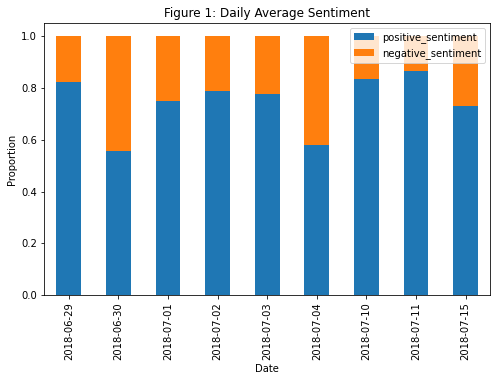

In [34]:
my_plot1 = grouped[['positive_sentiment','negative_sentiment']].plot(kind='bar', stacked=True,figsize = (8,5),title = "Figure 1: Daily Average Sentiment")

my_plot1.set_ylabel("Proportion")


Text(17.200000000000003, 0.5, 'Proportion')

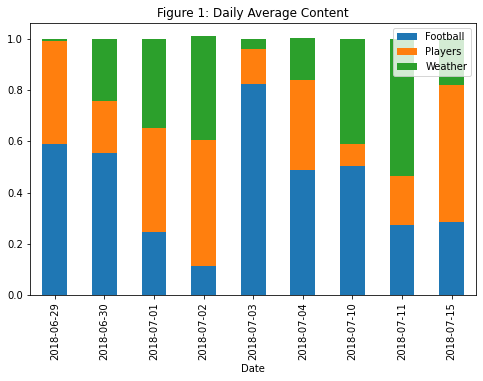

In [35]:
my_plot2 = grouped[['Football','Players','Weather']].plot(kind='bar', stacked=True,figsize = (8,5),title = "Figure 1: Daily Average Content")

my_plot1.set_ylabel("Proportion")


# Not accounting for colinearity

In [36]:
y1 = grouped['Attendance']
y1 = grouped['Attendance'].apply(lambda x: math.log(x))
x1 = grouped[['negative_sentiment','positive_sentiment','Football','Players','Weather']]
#x1 = grouped[['positive_sentiment','Football','Weather']]

x1 = sm.add_constant(x1, has_constant='add')
OLS_Regression_noln = sm.OLS(y1,x1).fit()
print(OLS_Regression_noln.summary())

                            OLS Regression Results                            
Dep. Variable:             Attendance   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.047
Date:                Fri, 24 Sep 2021   Prob (F-statistic):              0.519
Time:                        22:01:54   Log-Likelihood:                 7.0192
No. Observations:                   9   AIC:                            -2.038
Df Residuals:                       3   BIC:                           -0.8550
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                251.8843    200

/Users/george/Documents/Holland_Uni/Year_4/learning-from-big-data-master/env/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


# Accounting for colinearity

In [37]:
y1 = grouped['Attendance']
y1 = grouped['Attendance'].apply(lambda x: math.log(x))
x1 = grouped[['positive_sentiment','Players','Weather']]

#x1 = preprocessing.scale(x1)
#y1 = preprocessing.scale(y1)

x1 = sm.add_constant(x1, has_constant='add')
OLS_Regression_noln = sm.OLS(y1,x1).fit()
print(OLS_Regression_noln.summary())

                            OLS Regression Results                            
Dep. Variable:             Attendance   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.016
Date:                Fri, 24 Sep 2021   Prob (F-statistic):              0.459
Time:                        22:01:54   Log-Likelihood:                 4.6170
No. Observations:                   9   AIC:                            -1.234
Df Residuals:                       5   BIC:                           -0.4452
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 10.1808      0

/Users/george/Documents/Holland_Uni/Year_4/learning-from-big-data-master/env/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))
